# Setup

In [1]:
import os
import sys
import subprocess
import math
import json

import numpy as np
import pandas as pd
from matplotlib import pyplot as pl
import seaborn as sns
import scipy as sp

import anndata as ad
import scanpy as sc

### User variables

In [2]:
cell_type = str("Bulk")
CT_MAP_JSON_PATH = "config/cell-type_groupings/hca_brain-organoids/bulk.json"

RUN_ID = "meqtl_oct1_bulk"
DATASET_ID = "hca_brain-organoids"

In [3]:
PROJ_ROOT = "/home/fichtner/projects/footprintQTL"
HCA_BORGS_PROJ = "data/datasets/hca_brain-organoids/"
ATAC_PEAKS_PATH = os.path.join(PROJ_ROOT, "data/datasets/hca_brain-organoids_processed/chromatin_accessibility/peak-matrix_rna-qc-cells_norm-reads-in-tss.h5ad")
RNA_AD_PATH = os.path.join(PROJ_ROOT, "data/datasets/hca_brain-organoids/outputs_allsamples/sabrina_allsamples_rna_final_after_atac.h5ad")

In [4]:
bedtools_bin = '/home/fichtner/.conda/envs/ian/bin/bedtools'

In [5]:
min_cells = 10 # All cts: cell-level | Minimum amount of cells a peak needs to for the peak to be retained (required for functions to work)

n_top_hvps = 10000 # 1 ct: cell-level | Top n ranked peaks to consider in highly-variable-peaks
min_mean_acells = 0.0125
max_mean_acells = 3

min_pval = 0.01 # Min p-value for marker peaks to be considered in the first place in differential peak accessibility
n_top_markers = 10000 # All cts: donor-level (cell agg.) | Top n ranking markers peaks to consider

min_mean_adonors = 0.002
min_donors = 0.26
min_score = 9

n_ca_PCs = 5 # Nr of chromatin accessibility PCs used as covariate

### Variables

In [6]:
os.chdir(PROJ_ROOT)

sys.path.append(os.path.join(PROJ_ROOT, "code"))
from helpers.helpers import ct_format, ct_format_alt, create_folder

In [7]:
cell_type_alt = ct_format_alt(cell_type)
cell_type = ct_format(cell_type)

In [8]:
ct_map_id = os.path.basename(CT_MAP_JSON_PATH).split('.')[0]

# Get ct-ann --> grouped-ct mappings
with open(CT_MAP_JSON_PATH, 'r') as f:
    ct_map = json.load(f)

# Format
ct_map_alt = {ct_format_alt(key): [ct_format_alt(e) for e in listt] for key, listt in ct_map.items()}
ct_map_i_alt = {ct_format_alt(old_ct): ct_format_alt(new_ct) for new_ct, old_cts in ct_map.items() for old_ct in old_cts}

ct_map = {ct_format(key): [ct_format(e) for e in listt] for key, listt in ct_map.items()}
ct_map_i = {old_ct: new_ct for new_ct, old_cts in ct_map.items() for old_ct in old_cts}

### Artifact donors

In [9]:
# # TMP
# PROJECT_PATH = '/home/fichtner/projects/footprintQTL'
# DATA_PATH = '/omics/groups/OE0540/internal/projects/HCA_organoid_2/cemm_sabrina-20Jul2022/'
# RNA_AD = 'outputs_allsamples/sabrina_allsamples_rna_final_after_atac.h5ad'

# import sys
# sys.path.append(PROJECT_PATH + "/code")
# from helpers.helpers import ct_format, get_anndata_coldata

# cells_coldata = get_anndata_coldata(os.path.join(DATA_PATH, RNA_AD))[0]
# del cells_coldata

In [10]:
# Exclude for some weird reason, samples in QC but not in other files
artifact_donors = {'SAMEA2474458', 'SAMEA2555012'}

# Get data

## Chromatin accessibility cell-level anndata

In [11]:
borgs_tile_mat = ad.read_h5ad(ATAC_PEAKS_PATH)

# Format
borgs_tile_mat.var_names = borgs_tile_mat.var['peak_name']
borgs_tile_mat.obs['cell_type'] = borgs_tile_mat.obs['cell_type'].apply(ct_format)
borgs_tile_mat.obs['cell_type'] = borgs_tile_mat.obs['cell_type'].map(ct_map_i).astype('category')

# Filter cell-types marked 'Discard'
if 'Discard' in borgs_tile_mat.obs['cell_type'].cat.categories:
    borgs_tile_mat = borgs_tile_mat[~(borgs_tile_mat.obs['cell_type'] == 'Discard'), :].copy()
    
    if 'Discard' in borgs_tile_mat.obs['cell_type'].cat.categories:
        borgs_tile_mat.obs['cell_type'] = borgs_tile_mat.obs['cell_type'].cat.remove_categories('Discard')

print(borgs_tile_mat.obs['cell_type'].cat.categories)
borgs_tile_mat

Index(['Bulk'], dtype='object')


AnnData object with n_obs × n_vars = 214375 × 736845
    obs: 'BlacklistRatio', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PassQC', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample', 'TSSEnrichment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'donor_id', 'clone', 'organoid', 'donor', 'leiden', 'stressed_vs_unstressed_celltypes', 'ReadsInPeaks', 'FRIP', 'barcode', 'batch', 'barcode_batch', 'cell_type'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type'

In [12]:
borgs_tile_mat.obs['cell_type']

index_name
CCTAAATCACATAACT-1_sSL0163     Bulk
GCTGCAATCCTTAGTT-1_sSL0108     Bulk
AGTCTTGCAGGCGAGT-1_sSL0161     Bulk
TGACTTAAGTAATCCA-1_sSL0113A    Bulk
CAATGTGGTTGAGGTC-1_sSL0149     Bulk
                               ... 
TGTTATGAGAAGGTGC-1_sSL0112A    Bulk
CATTGTAAGTTAGGCT-1_sSL0089     Bulk
AGGTCTTAGTTAGTTG-1_sSL0099     Bulk
CGAGCTGGTCACAAAT-1_sSL0112A    Bulk
GTTACGTAGATAGACG-1_sSL0093     Bulk
Name: cell_type, Length: 214375, dtype: category
Categories (1, object): ['Bulk']

In [13]:
# Remove artifact donors
donors_qc = ~borgs_tile_mat.obs['donor_id'].isin(artifact_donors)

borgs_tile_mat = borgs_tile_mat[donors_qc, :].copy()

borgs_tile_mat.shape

(210857, 736845)

### Get cell-type anndata

In [14]:
caPeaks_1ct = borgs_tile_mat[borgs_tile_mat.obs['cell_type'] == cell_type, :].copy()
caPeaks_1ct

AnnData object with n_obs × n_vars = 210857 × 736845
    obs: 'BlacklistRatio', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PassQC', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample', 'TSSEnrichment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'donor_id', 'clone', 'organoid', 'donor', 'leiden', 'stressed_vs_unstressed_celltypes', 'ReadsInPeaks', 'FRIP', 'barcode', 'batch', 'barcode_batch', 'cell_type'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type'

In [15]:
n_peaks_og = caPeaks_1ct.n_vars

In [16]:
caPeaks_1ct.obs['cell_type'].cat.categories

Index(['Bulk'], dtype='object')

### Hard peak filter: Remove peaks w min cell nr within ct

In [17]:
# Required for HVPeaks
sc.pp.filter_genes(caPeaks_1ct, min_cells=min_cells)
n_cells, n_peaks_post_min_cells = caPeaks_1ct.shape
caPeaks_1ct.shape

(210857, 736845)

In [18]:
n_peaks_min_cells = n_peaks_og - n_peaks_post_min_cells

In [19]:
# Remove hard-filtered peaks from cell-level anndata
borgs_tile_mat = borgs_tile_mat[:, caPeaks_1ct.var_names].copy()

### Cell-type cells level stats

In [20]:
# describe_result = sp.stats.describe(caPeaks_1ct.X.toarray(), axis=0)

# stats = {
#     'nobs': [describe_result.nobs] * len(describe_result.mean),
#     'min': describe_result.minmax[0],
#     'max': describe_result.minmax[1],
#     'mean': describe_result.mean,
#     'variance': describe_result.variance,
#     'skewness': describe_result.skewness,
#     'kurtosis': describe_result.kurtosis
# }

# # Create a DataFrame with the statistics
# df = pd.DataFrame(stats)
# df = df.transpose().reset_index().rename(columns={'index': 'statistic'}).set_index('statistic')

# df

### Init donor-level CA matrix

In [21]:
caPeaks_1ct_agg = sc.get.aggregate(caPeaks_1ct,
                                   by=['donor_id'],
                                   func=['mean'],
                                   axis='obs')

caPeaks_1ct_agg.X = caPeaks_1ct_agg.layers['mean'].copy()
del caPeaks_1ct_agg.layers['mean']

n_donors = caPeaks_1ct_agg.n_obs

caPeaks_1ct_agg

AnnData object with n_obs × n_vars = 70 × 736845
    obs: 'donor_id'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type', 'n_cells'

In [22]:
agg_df = caPeaks_1ct_agg.to_df()
agg_df

peak_name,chr1:804695:805195:501:*:1,chr1:811018:811518:501:*:2,chr1:817077:817577:501:*:3,chr1:817816:818316:501:*:4,chr1:819782:820282:501:*:5,chr1:826617:827117:501:*:6,chr1:827319:827819:501:*:7,chr1:830673:831173:501:*:8,chr1:838258:838758:501:*:9,chr1:849809:850309:501:*:10,...,chrX:155880442:155880942:501:*:19669,chrX:155881013:155881513:501:*:19670,chrX:155881586:155882086:501:*:19671,chrX:155888143:155888643:501:*:19672,chrX:155889305:155889805:501:*:19673,chrX:155891803:155892303:501:*:19674,chrX:155941826:155942326:501:*:19675,chrX:155956608:155957108:501:*:19676,chrX:155959222:155959722:501:*:19677,chrX:155966839:155967339:501:*:19678
SAMEA2420640,0.001298,0.001443,0.001896,0.000880,0.003620,0.006175,0.055694,0.000000,0.000000,0.001444,...,0.003879,0.067043,0.007543,0.003228,0.002261,0.000000,0.002833,0.010751,0.000894,0.001466
SAMEA2433566,0.001032,0.000000,0.010437,0.000900,0.000000,0.005115,0.053394,0.000000,0.000000,0.005625,...,0.005151,0.074174,0.009522,0.000485,0.000000,0.000000,0.000000,0.004252,0.000000,0.000000
SAMEA2445779,0.000198,0.003728,0.000432,0.000651,0.003289,0.004924,0.052959,0.000244,0.002375,0.000852,...,0.005109,0.074190,0.008606,0.006081,0.000928,0.002593,0.003183,0.005989,0.001981,0.003728
SAMEA2445784,0.000000,0.003247,0.001779,0.000293,0.001916,0.007816,0.054037,0.000819,0.000263,0.002262,...,0.010229,0.071965,0.006797,0.005488,0.002854,0.008814,0.003763,0.009007,0.002321,0.005449
SAMEA2459959,0.000000,0.000000,0.004889,0.004577,0.000000,0.008981,0.069085,0.000000,0.000000,0.012882,...,0.000000,0.074389,0.000000,0.001064,0.004045,0.000000,0.000000,0.006273,0.000000,0.011641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA3977051,0.000872,0.001099,0.003846,0.000406,0.001092,0.006675,0.047560,0.000000,0.006878,0.001016,...,0.009097,0.087049,0.006323,0.004444,0.002403,0.009077,0.003301,0.011139,0.001814,0.000921
SAMEA4089453,0.000884,0.001087,0.004447,0.002036,0.000759,0.007706,0.057282,0.000200,0.000138,0.009637,...,0.006691,0.061436,0.011078,0.001829,0.004396,0.002353,0.000815,0.005671,0.000939,0.001152
SAMEA4343052,0.000000,0.003276,0.005437,0.000320,0.001512,0.007395,0.051915,0.000000,0.000345,0.000277,...,0.004253,0.070545,0.012506,0.004739,0.001584,0.009330,0.003431,0.004853,0.001474,0.003110
SAMEA4451098,0.000647,0.004422,0.003298,0.000607,0.001741,0.005409,0.053924,0.000500,0.000000,0.000859,...,0.008313,0.082750,0.016179,0.004406,0.003012,0.007455,0.004467,0.007757,0.003447,0.000678


### Init ct-donor-level CA matrix

In [23]:
caPeaks_agg_cd = sc.get.aggregate(borgs_tile_mat,
                                   by=['cell_type', 'donor_id'],
                                   func=['mean'],
                                   axis='obs')

caPeaks_agg_cd.X = caPeaks_agg_cd.layers['mean'].copy()
del caPeaks_agg_cd.layers['mean']

caPeaks_agg_cd

AnnData object with n_obs × n_vars = 70 × 736845
    obs: 'cell_type', 'donor_id'
    var: 'chr', 'start', 'end', 'strand', 'peak_name', 'score', 'GC', 'nearest_gene', 'peak_type'

### Init donor-batch-level CA matrix

In [24]:
# caPeaks_agg_cdb = sc.get.aggregate(borgs_tile_mat,
#                                    by=['cell_type', 'donor_id', 'batch'],
#                                    func=['mean'],
#                                    axis='obs')

# caPeaks_agg_cdb.X = caPeaks_agg_cdb.layers['mean'].copy()
# del caPeaks_agg_cdb.layers['mean']

# n_donor_batch = caPeaks_agg_cdb.obs[caPeaks_agg_cdb.obs['cell_type'] == cell_type].shape[0]

# caPeaks_agg_cdb

# Cell-level analysis

## Peak filter: DAPeaks

/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_utils.py:29: RuntimeWarning: Mean of empty slice.
  return X.mean(axis=axis, dtype=dtype)
/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:432: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin, ymax)


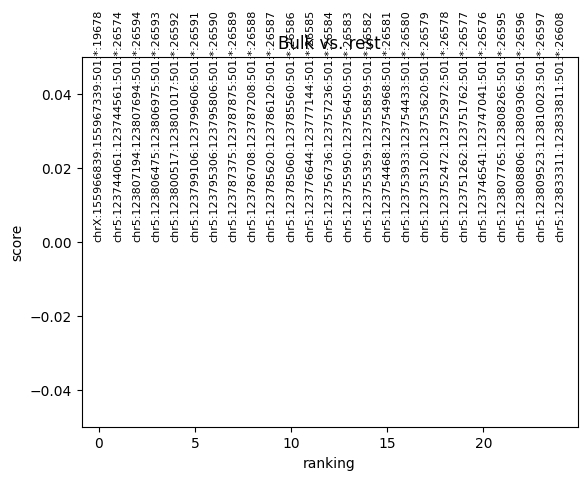

In [25]:
sc.tl.rank_genes_groups(caPeaks_agg_cd, groupby='cell_type', method='t-test', rankby_abs=True)
sc.pl.rank_genes_groups(caPeaks_agg_cd, n_genes=25, sharey=False)

In [26]:
daps = sc.get.rank_genes_groups_df(caPeaks_agg_cd, group=cell_type, pval_cutoff=min_pval)
peaks_markers = set(daps['names'][0:n_top_markers])
daps

,names,scores,logfoldchanges,pvals,pvals_adj


In [27]:
daps_out_path = f"data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/chromatin_accessibility/differentially-accessible-peaks/{ct_map_id}/{cell_type}.tsv"

create_folder(os.path.dirname(os.path.abspath(daps_out_path)))

daps.to_csv(daps_out_path, sep='\t')

In [28]:
del caPeaks_agg_cd

## Peaks filter: intersecting w eQTLs

### Make eQTLs bed file

In [29]:
eqtls = pd.read_csv(os.path.join(HCA_BORGS_PROJ, "eQTL_mapping/eSNPs_significant_all_celltypes_HVGs.tsv"),
                   sep='\t',
                   header=0,
                   index_col=21)
eqtls.columns

Index(['snp_id', 'p_value', 'beta', 'beta_se', 'empirical_feature_p_value',
       'feature_chromosome', 'feature_start', 'feature_end', 'gene_name',
       'n_samples', 'n_e_samples', 'alpha_param', 'beta_param', 'rho',
       'snp_chromosome', 'snp_position', 'assessed_allele', 'call_rate', 'maf',
       'hwe_p', 'feature_id', 'global_corrected_pValue',
       'global_corrected_pValue_BH', 'global_corrected_pValue_BF', 'celltype'],
      dtype='object')

In [30]:
eqtls

,snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,feature_end,gene_name,n_samples,...,snp_position,assessed_allele,call_rate,maf,hwe_p,feature_id,global_corrected_pValue,global_corrected_pValue_BH,global_corrected_pValue_BF,celltype
QTL,,,,,,,,,,,,,,,,,,,,,
ENSG00000269376-chr13_112983450_T_C,chr13_112983450_T_C,0.000066,-0.364427,0.092665,0.000000e+00,13,113009671,113010319,NaN,277,...,112983450,C,1.0,0.044776,1.000000,ENSG00000269376,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000183463-chr13_27824764_C_T,chr13_27824764_C_T,0.047441,-0.089739,0.045430,0.000000e+00,13,27977717,27988693,URAD,277,...,27824764,C,1.0,0.089552,0.073438,ENSG00000183463,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000259182-chr15_101221494_A_C,chr15_101221494_A_C,0.202509,-0.088910,0.069866,0.000000e+00,15,101168530,101170821,NaN,277,...,101221494,A,1.0,0.044776,0.110206,ENSG00000259182,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000286922-chr12_127567286_A_G,chr12_127567286_A_G,0.265404,-0.030918,0.027792,0.000000e+00,12,127486938,127533242,NaN,277,...,127567286,G,1.0,0.074627,1.000000,ENSG00000286922,0.000000e+00,0.000000e+00,0.000000e+00,immature_EN
ENSG00000286246-chr12_129375924_C_G,chr12_129375924_C_G,0.949835,-0.000101,0.001608,4.101945e-163,12,129622929,129625366,NaN,277,...,129375924,C,1.0,0.089552,0.073438,ENSG00000286246,1.930191e-161,2.223254e-161,1.111627e-160,immature_EN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000250842-chr5_145190494_A_T,chr5_145190494_A_T,0.000033,0.535958,0.130797,1.828702e-02,5,145337932,145381670,NaN,310,...,145190494,A,1.0,0.316176,1.000000,ENSG00000250842,4.610052e-02,4.610052e-02,1.000000e+00,Differentiating_RG
ENSG00000267537-chr19_28873752_G_A,chr19_28873752_G_A,0.000285,-0.620958,0.172965,1.854836e-02,19,28602379,28648303,NaN,310,...,28873752,G,1.0,0.066176,0.246147,ENSG00000267537,4.669823e-02,4.669823e-02,1.000000e+00,Differentiating_RG
ENSG00000287056-chr6_168100952_C_G,chr6_168100952_C_G,0.001926,-0.216988,0.070509,1.932144e-02,6,168217032,168220262,NaN,310,...,168100952,C,1.0,0.102941,1.000000,ENSG00000287056,4.858106e-02,4.858106e-02,1.000000e+00,Differentiating_RG


In [31]:
eqtls['celltype'].unique()

array(['immature_EN', 'Stressed_Prog', 'IPC', 'Glia', 'UL-EN',
       'Midbrain_EN', 'Dividing_Glia', 'DL-EN', 'Interneurons',
       'Stressed_Neurons', 'Differentiating_RG'], dtype=object)

In [32]:
cell_type_alt

'Bulk'

In [33]:
# Make eQTL bed file

eqtls_bed = eqtls[['snp_chromosome', 'snp_position', 'beta', 'celltype']].copy()

# Filter out 'Discard' marked cell-types
eqtls_bed = eqtls_bed[eqtls_bed['celltype'].isin(ct_map_alt['Discard'])].copy()

eqtls_bed['start'] = eqtls_bed['snp_position'] - 1 # Make index 0-based open
eqtls_bed['strand'] = '+'
eqtls_bed.reset_index(inplace=True)
eqtls_bed['chr'] = 'chr' + eqtls_bed['snp_chromosome'].astype(str)
eqtls_bed = eqtls_bed.rename(columns={'snp_position': 'end', 'QTL': 'id', 'beta': 'score'})

eqtls_bed = eqtls_bed[['chr', 'start', 'end', 'id', 'score', 'strand']].sort_values(by=['chr', 'start'], ascending=[True, True])
        
eqtls_bed_path = f'data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/eQTLs/{ct_map_id}/eQTLs_{cell_type}.tsv'

create_folder(os.path.dirname(os.path.abspath(eqtls_bed_path)))

eqtls_bed.to_csv(eqtls_bed_path, sep='\t', header=False, index=False)

eqtls_bed

,chr,start,end,id,score,strand
89,chr1,31667956,31667957,ENSG00000203620-chr1_31667957_G_A,-0.362039,+
84,chr1,41152241,41152242,ENSG00000286668-chr1_41152242_C_G,-0.047192,+
83,chr1,41964567,41964568,ENSG00000044012-chr1_41964568_T_A,-0.015555,+
82,chr1,50418557,50418558,ENSG00000284645-chr1_50418558_G_C,-0.030638,+
88,chr1,51296414,51296415,ENSG00000227070-chr1_51296415_A_G,-0.411862,+
...,...,...,...,...,...,...
52,chr4,79528284,79528285,ENSG00000156269-chr4_79528285_AC_A,0.452924,+
20,chr4,89627551,89627552,ENSG00000276542-chr4_89627552_C_T,-0.000616,+
15,chr4,93323765,93323766,ENSG00000250908-chr4_93323766_C_T,-0.131579,+
4,chr4,94676404,94676405,ENSG00000249599-chr4_94676405_C_T,-0.101460,+


### Make peaks bed file

In [34]:
peaks_bed = borgs_tile_mat.var[['chr', 'start', 'end', 'peak_name', 'score']].copy()
peaks_bed['start'] = peaks_bed['start'] - 1
peaks_bed['strand'] = '+'

peaks_bed_path = f'data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/chromatin_accessibility/peaks/{ct_map_id}/{cell_type}.bed'

create_folder(os.path.dirname(os.path.abspath(peaks_bed_path)))

peaks_bed.to_csv(peaks_bed_path, sep='\t', header=False, index=False)

print(len(peaks_bed))
peaks_bed

736845


,chr,start,end,peak_name,score,strand
peak_name,,,,,,
chr1:804695:805195:501:*:1,chr1,804694,805195,chr1:804695:805195:501:*:1,3.01127,+
chr1:811018:811518:501:*:2,chr1,811017,811518,chr1:811018:811518:501:*:2,17.72120,+
chr1:817077:817577:501:*:3,chr1,817076,817577,chr1:817077:817577:501:*:3,19.46110,+
chr1:817816:818316:501:*:4,chr1,817815,818316,chr1:817816:818316:501:*:4,10.06330,+
chr1:819782:820282:501:*:5,chr1,819781,820282,chr1:819782:820282:501:*:5,2.71269,+
...,...,...,...,...,...,...
chrX:155891803:155892303:501:*:19674,chrX,155891802,155892303,chrX:155891803:155892303:501:*:19674,11.25430,+
chrX:155941826:155942326:501:*:19675,chrX,155941825,155942326,chrX:155941826:155942326:501:*:19675,9.46511,+
chrX:155956608:155957108:501:*:19676,chrX,155956607,155957108,chrX:155956608:155957108:501:*:19676,42.66500,+


### Peaks intersecting w eQTLs

In [35]:
try:
    result = subprocess.run([bedtools_bin, 'intersect' , '-a', peaks_bed_path, '-b', eqtls_bed_path, '-u'], text=True, capture_output=True)

    # with open(f'data/datasets/hca_brain-organoids_processed/chromatin_accessibility/peaks_{cell_type}_filt-eqtls.bed', 'w') as f:
        # f.write(result.stdout)

    peaks_eqtl = set([i.split('\t')[3] for i in result.stdout.split('\n')[:-1]])
    
except subprocess.CalledProcessError as e:
    
    print(f"Command failed with error: {e.stderr}")

### Peaks filter: close to eGenes

In [36]:
eGenes = set(eqtls.loc[~eqtls['gene_name'].isna(), 'gene_name'].unique())

In [37]:
len(eGenes)

1204

In [38]:
peaks_eGenes = set(borgs_tile_mat.var[borgs_tile_mat.var['nearest_gene'].isin(eGenes)].index)

len(peaks_eGenes)

33062

In [39]:
del borgs_tile_mat

# Cell-type level analysis

### Peak filter: HVPeaks

In [40]:
# Remove batches w with min cell nr
cell_counts_per_donor_batch = caPeaks_1ct.obs.groupby('batch').transform('size')
ca_1ct_batch_filtered = caPeaks_1ct[cell_counts_per_donor_batch >= 10, :].copy()
sum(cell_counts_per_donor_batch >= 10)

210857

/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


/home/fichtner/.conda/envs/ian/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


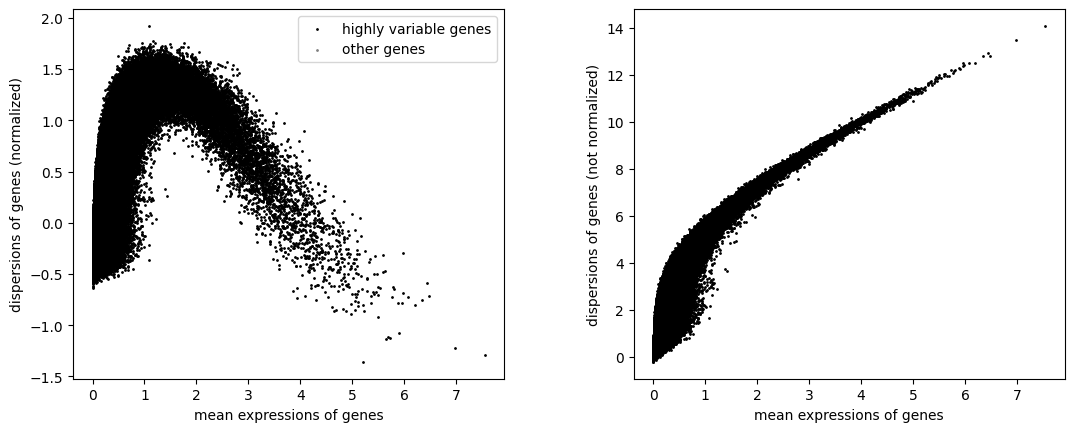

In [41]:
# Seurat (expect log)
sc.pp.highly_variable_genes(ca_1ct_batch_filtered, flavor='seurat', batch_key='batch', n_top_genes=ca_1ct_batch_filtered.n_vars)
sc.pl.highly_variable_genes(ca_1ct_batch_filtered)

In [42]:
# Extract top n HVPs
merge = pd.merge(ca_1ct_batch_filtered.var['means'].to_frame(),
              ca_1ct_batch_filtered.var['highly_variable_nbatches'].to_frame(),
              left_index=True,
              right_index=True,
              how='inner')

merge = pd.merge(merge,
              ca_1ct_batch_filtered.var['dispersions_norm'].abs().to_frame(),
              left_index=True,
              right_index=True,
              how='inner')

merge = merge[(merge['means'] > min_mean_acells) & (merge['means'] < max_mean_acells)]

merge = merge.sort_values(by=['highly_variable_nbatches', 'dispersions_norm'], ascending=[False, False])
peaks_hvp = set(merge[0:n_top_hvps].index)

In [43]:
# peaks_hvp = set(ca_1ct_batch_filtered.var[ca_1ct_batch_filtered.var['highly_variable']].index)

In [44]:
# from scipy.sparse import issparse

# # Convert sparse matrix to dense format if necessary
# data_matrix = caPeaks_1ct.X.toarray() if issparse(caPeaks_1ct.X) else caPeaks_1ct.X

# # Check for NaN values
# print("Number of NaN values in data:", np.isnan(data_matrix).sum())

# # Check for infinite values
# print("Number of infinite values in data:", np.isinf(data_matrix).sum())

# # Check for rows with all zeros (optimized for sparse matrices)
# if issparse(caPeaks_1ct.X):
#     zero_rows = np.array((caPeaks_1ct.X != 0).sum(axis=1)).flatten() == 030686794
# else:
#     zero_rows = np.sum(data_matrix == 0, axis=1) == data_matrix.shape[1]

# print("Number of rows with all zero values:", zero_rows.sum())

In [45]:
del ca_1ct_batch_filtered

## Peaks filter: min mean across donors

In [46]:
agg_mean = agg_df.mean()

In [47]:
agg_mean.describe()

count    736845.000000
mean          0.007412
std           0.020659
min           0.000042
25%           0.001362
50%           0.002416
75%           0.005141
max           0.584630
dtype: float64

<Axes: title={'center': 'Peak mean across donors distr.'}, ylabel='#'>

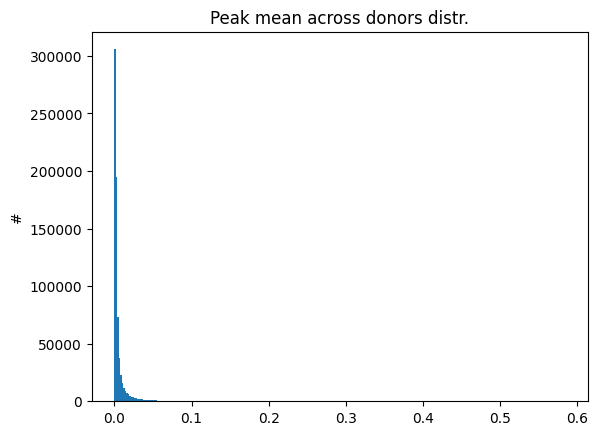

In [48]:
agg_mean.plot(kind='hist',
              bins=300, title="Peak mean across donors distr.",
              xlabel="",
              ylabel="#")

<Axes: title={'center': 'Peak mean across donors ZOOM distr.'}, ylabel='#'>

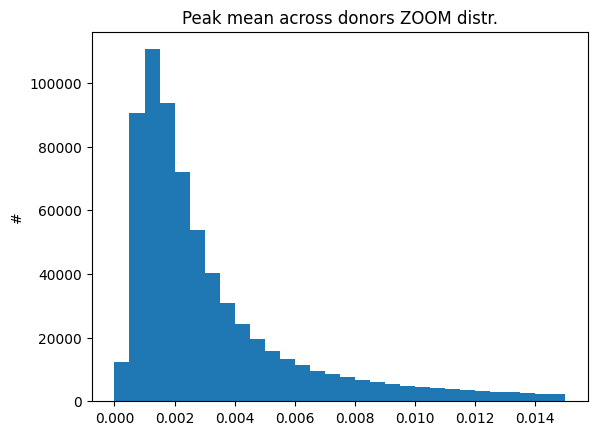

In [49]:
agg_mean.plot(kind='hist', 
              bins=np.linspace(0, 0.015, 31),
              title="Peak mean across donors ZOOM distr.",
              xlabel="",
              ylabel="#")

<Axes: title={'center': 'Peak mean across donors ZOOM distr.'}, ylabel='Density'>

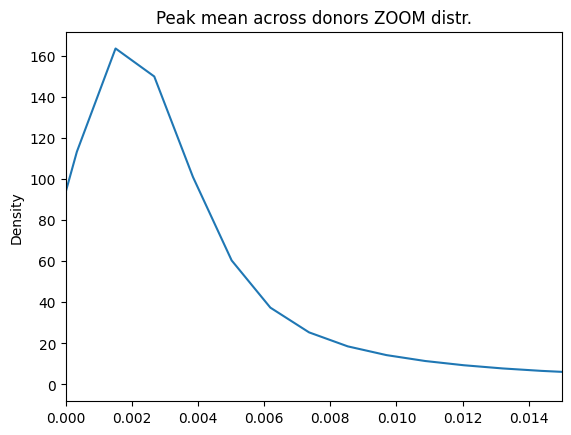

In [50]:
agg_mean.plot(kind='density',
              xlim=[0, 0.015],
              title="Peak mean across donors ZOOM distr.",
              xlabel="")

In [51]:
peaks_min_mean = set(agg_df.loc[:, agg_mean > min_mean_adonors].columns.tolist())

## Peaks filter: min donors with non-zero ca count

In [52]:
non0s = (agg_df != 0).mean()

non0s.describe()

count    736845.000000
mean          0.901318
std           0.093971
min           0.157143
25%           0.842857
50%           0.928571
75%           0.971429
max           1.000000
dtype: float64

<Axes: title={'center': 'Non-zero donor count distr.'}, ylabel='#'>

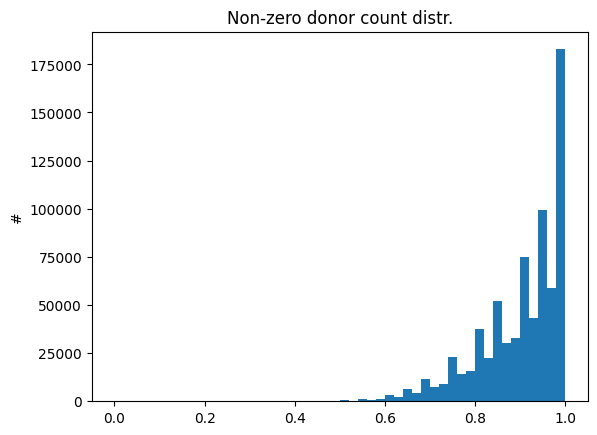

In [53]:
non0s.plot(kind='hist',
           bins=np.linspace(0, 1, 51),
           title="Non-zero donor count distr.",
           ylabel="#")

In [54]:
peaks_min_donors = set(agg_df.loc[:, non0s > min_donors].columns.to_list())

In [55]:
# Density of CA

non0 = np.count_nonzero(caPeaks_1ct_agg.X)
all_ = np.product(caPeaks_1ct_agg.X.shape)
general_ca_density = round(non0 / all_, 2)
print(f'General matrix density: {general_ca_density}')

General matrix density: 0.9


## Peaks filter: min peak score

In [56]:
peak_scores = caPeaks_1ct_agg.var['score']

In [57]:
peak_scores.describe()

count    736845.000000
mean         19.414349
std          28.508345
min           1.028790
25%           5.897420
50%          10.041400
75%          21.127300
max        1017.970000
Name: score, dtype: float64

<Axes: title={'center': 'Peak score distr.'}, ylabel='#'>

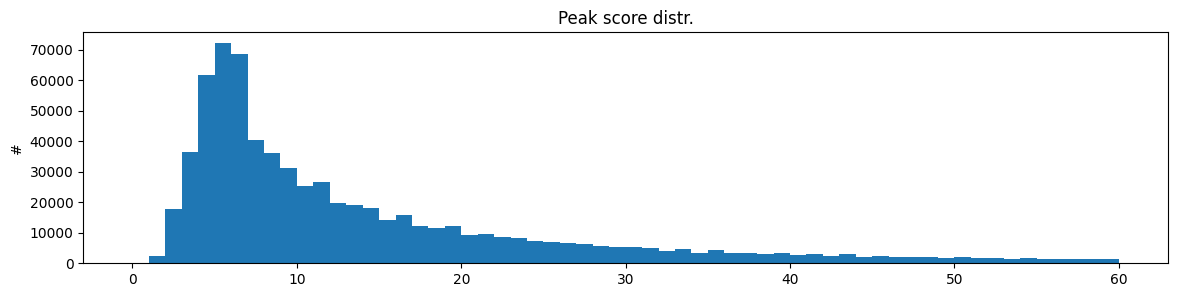

In [58]:
peak_scores.plot(kind='hist',
                 bins=np.linspace(0, 60, 61),
                 figsize=(14,3),
                 title="Peak score distr.",
                 ylabel="#")

In [59]:
peaks_min_score = set(caPeaks_1ct_agg.var[(caPeaks_1ct_agg.var['score'] >= min_score).tolist()].index.tolist())

In [60]:
del agg_df

## CA matrix: final peaks filtering step and export

In [61]:
print(f'Len peaks_hvp = {len(peaks_hvp)}\n' \
      f'peaks_hvp = {list(peaks_hvp)[0:4]}')

print(f'Len peaks_markers = {len(peaks_markers)}\n' \
      f'peaks_markers = {list(peaks_markers)[0:4]}')

print(f'Len peaks_eqtl = {len(peaks_eqtl)}\n' \
      f'peaks_eqtl = {list(peaks_eqtl)[0:4]}')

print(f'Len peaks_eGenes = {len(peaks_eGenes)}\n' \
      f'peaks_eGenes = {list(peaks_eGenes)[0:4]}')

print(f'Len peaks_min_mean = {len(peaks_min_mean)}\n' \
      f'peaks_min_mean = {list(peaks_min_mean)[0:4]}')

print(f'Len peaks_min_donors = {len(peaks_min_donors)}\n' \
      f'peaks_min_donors = {list(peaks_min_donors)[0:4]}')

print(f'Len peaks_min_score = {len(peaks_min_score)}\n' \
      f'peaks_min_score = {list(peaks_min_score)[0:4]}')

Len peaks_hvp = 10000
peaks_hvp = ['chr1:174022196:174022696:501:*:44496', 'chr16:30814217:30814717:501:*:9625', 'chr17:42744817:42745317:501:*:12393', 'chr5:176619149:176619649:501:*:42180']
Len peaks_markers = 0
peaks_markers = []
Len peaks_eqtl = 12
peaks_eqtl = ['chr1:50418091:50418591:501:*:19698', 'chr22:35257728:35258228:501:*:6166', 'chr4:16675682:16676182:501:*:5583', 'chr4:79528192:79528692:501:*:17656']
Len peaks_eGenes = 33062
peaks_eGenes = ['chr1:98793088:98793588:501:*:32029', 'chr19:16893278:16893778:501:*:7479', 'chr3:27611393:27611893:501:*:7332', 'chr6:41507726:41508226:501:*:12798']
Len peaks_min_mean = 429643
peaks_min_mean = ['chr5:90941273:90941773:501:*:19402', 'chr9:34191527:34192027:501:*:7445', 'chr7:155401156:155401656:501:*:38189', 'chr2:12720249:12720749:501:*:4490']
Len peaks_min_donors = 736842
peaks_min_donors = ['chr19:11452579:11453079:501:*:5512', 'chr14:38125419:38125919:501:*:4281', 'chrX:70168537:70169037:501:*:9890', 'chr14:41634203:41634703:501:

In [62]:
# Filter final peaks
final_peaks = list((peaks_hvp | peaks_markers | peaks_eqtl | peaks_eGenes) & (peaks_min_mean | peaks_min_donors | peaks_min_score)) # remove peaks_min_mean or peaks_min_donors

caPeaks_1ct_agg = caPeaks_1ct_agg[:, final_peaks].copy()

len(final_peaks)

42816

In [63]:
# Create CA matrix
ca_peaks_out = caPeaks_1ct_agg.to_df().T
ca_peaks_out = ca_peaks_out.rename_axis('peak_id')

In [64]:
len(ca_peaks_out.columns.tolist())

70

In [65]:
ca_donors = list(set(ca_peaks_out.columns.tolist()) - artifact_donors) # Should be redundand
len(ca_donors)

70

In [66]:
ca_peaks_out = ca_peaks_out[ca_donors]

print(ca_peaks_out.shape)
ca_peaks_out

(42816, 70)


,SAMEA2678742,SAMEA2595426,SAMEA2707499,SAMEA4451109,SAMEA2711371,SAMEA3973854,SAMEA2547899,SAMEA2420640,SAMEA3485958,SAMEA2645805,...,SAMEA2536416,SAMEA3967410,SAMEA3853161,SAMEA2698309,SAMEA2609971,SAMEA2536413,SAMEA2625592,SAMEA3854308,SAMEA3963885,SAMEA3962524
peak_id,,,,,,,,,,,,,,,,,,,,,
chr5:176619149:176619649:501:*:42180,0.093007,0.030809,0.071164,0.104957,0.068255,0.054264,0.067831,0.031518,0.073793,0.095350,...,0.048473,0.073474,0.036954,0.094770,0.046573,0.058689,0.080835,0.096592,0.055805,0.044574
chr1:98793088:98793588:501:*:32029,0.000598,0.001438,0.002195,0.001400,0.000000,0.002870,0.000874,0.004510,0.002173,0.001422,...,0.004374,0.000535,0.002918,0.001674,0.003123,0.000000,0.000331,0.000288,0.002245,0.003101
chr19:16893278:16893778:501:*:7479,0.001251,0.002104,0.006475,0.005216,0.000000,0.000711,0.002967,0.001244,0.003496,0.000848,...,0.002506,0.001173,0.002484,0.004515,0.007604,0.000000,0.003002,0.002729,0.001233,0.001464
chr3:27611393:27611893:501:*:7332,0.000000,0.000494,0.000499,0.002177,0.000000,0.000329,0.001507,0.000504,0.000580,0.000244,...,0.000324,0.000000,0.000639,0.000258,0.000000,0.012599,0.003359,0.000325,0.000419,0.000000
chr12:78209819:78210319:501:*:19149,0.056465,0.073863,0.041257,0.027184,0.082833,0.055324,0.039926,0.043297,0.035004,0.030764,...,0.023460,0.076776,0.022253,0.042676,0.011942,0.068305,0.105362,0.137540,0.029231,0.014693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr5:76499415:76499915:501:*:16095,0.001916,0.004816,0.000147,0.000000,0.000000,0.000374,0.000540,0.001197,0.001397,0.000230,...,0.000398,0.000715,0.001764,0.003694,0.004362,0.000833,0.000813,0.001499,0.000805,0.000541
chr3:143537173:143537673:501:*:36686,0.003046,0.008282,0.004667,0.001549,0.000000,0.001940,0.002890,0.005880,0.010492,0.002874,...,0.009667,0.008515,0.006343,0.004210,0.006067,0.006300,0.007927,0.003743,0.003954,0.005982
chr8:139154232:139154732:501:*:32713,0.000000,0.001592,0.000328,0.000000,0.000000,0.000689,0.000224,0.004107,0.000000,0.000000,...,0.008600,0.000000,0.000430,0.000362,0.000000,0.000000,0.000000,0.001048,0.000129,0.001139


In [67]:
# Export peak chromatin accessibility
ca_peaks_out_path = f"data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/chromatin_accessibility/peak_ca/{ct_map_id}/{cell_type}.tsv"

create_folder(os.path.dirname(os.path.abspath(ca_peaks_out_path)))

ca_peaks_out.round(6).to_csv(ca_peaks_out_path, sep='\t')

### CA matrix stats

In [68]:
_, mean_cells_donor, std_cells_donor, _, _, _, _, _ = caPeaks_1ct.obs.groupby('donor_id').size().describe()

donor_batch = caPeaks_1ct.obs.groupby(['donor_id', 'batch']).size()
donor_batch = donor_batch[donor_batch != 0]
n_donor_batches, mean_cells_donor_batch, std_cells_donor_batch, _, _, _, _, _ = donor_batch.describe()
n_donor_batches = int(n_donor_batches)

In [69]:
# Stats

stats_out_path = f"results/datasets/{DATASET_ID}/matrix-eQTL/{ct_map_id}/io_stats.tsv"

create_folder(os.path.dirname(os.path.abspath(stats_out_path)))

with open(stats_out_path, 'a') as f:
        
    msg = f'\n{RUN_ID}\t' \
            f'{cell_type}\t' \
            f'{general_ca_density}\t' \
            f'{n_cells}\t' \
            f'{n_donors}\t' \
            f'{mean_cells_donor}\t' \
            f'{std_cells_donor}\t' \
            f'{n_donor_batches}\t' \
            f'{mean_cells_donor_batch}\t' \
            f'{std_cells_donor_batch}\t' \
            f'{n_peaks_og}\t' \
            f'{n_peaks_min_cells}\t' \
            f'{n_peaks_post_min_cells}\t' \
            f'{len(peaks_hvp)}\t' \
            f'{len(peaks_markers)}\t' \
            f'{len(peaks_eqtl)}\t' \
            f'{len(peaks_eGenes)}\t' \
            f'{len(peaks_min_mean)}\t' \
            f'{len(peaks_min_donors)}\t' \
            f'{len(peaks_min_score)}\t' \
            f'{ca_peaks_out.shape[0]}\t' \
            f'{ca_peaks_out.shape[1]}'

    f.write(msg)
    print(msg)


meqtl_oct1_bulk	Bulk	0.9	210857	70	3012.2428571428572	2583.2698885283403	381	553.4304461942257	639.1589403822734	736845	0	736845	10000	0	12	33062	429643	736842	401476	42816	70


In [70]:
del ca_peaks_out
del caPeaks_1ct

# COV: peak locations

In [71]:
peak_locs = caPeaks_1ct_agg.var[['peak_name', 'chr', 'start', 'end']].copy()
peak_locs['start'] = peak_locs['start'] - 1

peak_locs

,peak_name,chr,start,end
peak_name,,,,
chr5:176619149:176619649:501:*:42180,chr5:176619149:176619649:501:*:42180,chr5,176619148,176619649
chr1:98793088:98793588:501:*:32029,chr1:98793088:98793588:501:*:32029,chr1,98793087,98793588
chr19:16893278:16893778:501:*:7479,chr19:16893278:16893778:501:*:7479,chr19,16893277,16893778
chr3:27611393:27611893:501:*:7332,chr3:27611393:27611893:501:*:7332,chr3,27611392,27611893
chr12:78209819:78210319:501:*:19149,chr12:78209819:78210319:501:*:19149,chr12,78209818,78210319
...,...,...,...,...
chr5:76499415:76499915:501:*:16095,chr5:76499415:76499915:501:*:16095,chr5,76499414,76499915
chr3:143537173:143537673:501:*:36686,chr3:143537173:143537673:501:*:36686,chr3,143537172,143537673
chr8:139154232:139154732:501:*:32713,chr8:139154232:139154732:501:*:32713,chr8,139154231,139154732


In [72]:
peak_locs_path = f"data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/chromatin_accessibility/peak_locations/{ct_map_id}/{cell_type}.tsv"

create_folder(os.path.dirname(os.path.abspath(peak_locs_path)))

peak_locs.to_csv(peak_locs_path, sep='\t', index=False)

In [73]:
del peak_locs

# COV: CA PCs

In [74]:
sc.pp.pca(caPeaks_1ct_agg) # Filtered for final peak set

In [75]:
ca_pcs = pd.DataFrame(caPeaks_1ct_agg.obsm['X_pca'][:, 0:n_ca_PCs]).set_index(caPeaks_1ct_agg.obs_names)
ca_pcs.columns = [f'caPC_{str(i)}' for i in range(1, n_ca_PCs + 1)]
ca_pcs = ca_pcs.T
ca_pcs = ca_pcs.rename_axis('id')

In [76]:
# ! Important that this doesn't change the sample nr! 2 cells above
ca_pcs = ca_pcs[ca_donors]

print(ca_pcs.shape)
ca_pcs

(5, 70)


,SAMEA2678742,SAMEA2595426,SAMEA2707499,SAMEA4451109,SAMEA2711371,SAMEA3973854,SAMEA2547899,SAMEA2420640,SAMEA3485958,SAMEA2645805,...,SAMEA2536416,SAMEA3967410,SAMEA3853161,SAMEA2698309,SAMEA2609971,SAMEA2536413,SAMEA2625592,SAMEA3854308,SAMEA3963885,SAMEA3962524
id,,,,,,,,,,,,,,,,,,,,,
caPC_1,0.348546,1.361199,-0.139383,0.685893,1.295069,0.108595,-0.525447,0.058303,-0.255168,-0.485635,...,-0.517757,1.081507,-0.799009,-0.003219,-1.181605,1.381924,1.460941,1.579016,-0.684777,-0.785479
caPC_2,-0.083167,-0.121511,-0.087175,1.018124,2.252304,-1.041368,-0.424844,-0.277669,-0.100596,-0.854988,...,-0.661999,0.433788,-0.774829,-0.838230,1.022353,-0.138999,-0.143831,-0.979940,0.601913,-0.362163
caPC_3,0.075319,-0.392559,-0.289926,0.131108,3.580719,0.476380,0.136986,-0.120735,-0.034258,0.275680,...,0.253267,-0.937823,0.206263,0.131030,-0.165235,-0.377844,-0.712095,0.243763,-0.293891,0.209106
caPC_4,-0.155512,-0.087332,0.400437,-0.265492,1.584183,-0.102408,0.231932,0.270361,0.207619,0.333942,...,0.044198,0.997354,0.166217,0.113149,-0.447800,0.504098,0.446115,-0.420302,-0.338710,-0.134739
caPC_5,0.326259,-0.315842,0.254779,0.621833,-0.282696,0.052962,0.026617,0.193478,0.254125,0.169305,...,-0.320228,0.111591,-0.397152,-0.150037,-0.193544,0.460130,-0.566647,-0.036001,-0.249354,-0.387105


In [77]:
ca_pcs_path = f"data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/chromatin_accessibility/ca_pcs/{ct_map_id}/{cell_type}.tsv"

create_folder(os.path.dirname(os.path.abspath(ca_pcs_path)))

ca_pcs.to_csv(ca_pcs_path, sep='\t')

In [78]:
del ca_pcs
del caPeaks_1ct_agg

# COV: Population structure

In [79]:
gt_pcs = pd.read_csv(os.path.join(HCA_BORGS_PROJ, "Genotypes/GT_PCs.tsv"), sep="\t", index_col=0)
gt_pcs_matrixQTL = gt_pcs.T
gt_pcs_matrixQTL = gt_pcs_matrixQTL.rename_axis('id')
gt_pcs_matrixQTL = gt_pcs_matrixQTL[ca_donors]

print(gt_pcs_matrixQTL.shape)
gt_pcs_matrixQTL

(20, 70)


iid,SAMEA2678742,SAMEA2595426,SAMEA2707499,SAMEA4451109,SAMEA2711371,SAMEA3973854,SAMEA2547899,SAMEA2420640,SAMEA3485958,SAMEA2645805,...,SAMEA2536416,SAMEA3967410,SAMEA3853161,SAMEA2698309,SAMEA2609971,SAMEA2536413,SAMEA2625592,SAMEA3854308,SAMEA3963885,SAMEA3962524
id,,,,,,,,,,,,,,,,,,,,,
PC1,534.269200,-22.360580,36.567543,8.252880,17.109028,-8.161153,4.767535,-61.166600,-10.119088,5.062119,...,-141.934390,2.542705,-26.086426,-587.087340,-11.026092,37.227420,-36.099750,15.455708,-45.389390,12.186271
PC2,-379.448880,16.850555,24.418850,11.945375,-2.294497,4.912662,42.741580,8.264520,-14.613321,17.896296,...,-963.927860,22.273016,12.337655,367.275100,-19.358488,29.959509,69.155190,43.419895,578.792850,42.351612
PC3,-755.075800,43.723200,56.386528,49.424560,12.770959,28.715384,25.009369,27.960432,35.091404,63.705715,...,-71.293526,0.096000,8.423677,587.046800,30.143745,7.322402,54.365560,29.958840,-521.950900,10.103840
PC4,562.314800,-1.413503,49.088190,46.583675,-54.440838,10.677946,-16.892120,66.276980,-3.814449,7.872817,...,18.946665,-23.513031,-15.730290,372.022800,61.010986,4.514056,8.240096,-21.306501,-901.205300,-94.013070
PC5,-588.629330,30.050665,-1.617828,-17.147549,-24.089895,-35.125046,-39.381832,0.795895,2.491865,-31.429237,...,-371.363400,44.935425,12.673084,49.229893,18.074700,20.821611,-5.430482,11.136854,563.941200,-3.526762
PC6,1117.132900,-39.224907,-71.204760,33.691920,-2.276715,16.425050,-43.932095,32.240032,4.828308,-26.485926,...,-577.124300,-61.912540,-49.799580,-182.055220,-9.483054,-4.850675,7.309116,-12.994849,270.644130,5.925176
PC7,116.265930,10.394878,4.270656,-7.336715,-7.592501,-5.632242,11.173185,24.833984,-21.255926,-70.128140,...,1123.644800,-53.017044,-11.844399,-386.220730,69.763690,-5.095608,-14.493244,-0.985342,269.105530,-43.594402
PC8,-23.191648,-32.527310,-3.997136,-11.409421,-6.455975,-17.070618,5.806158,36.857200,-12.550730,44.648506,...,-458.672880,20.081114,18.833464,-129.463040,-15.064022,-4.225716,-20.599740,-20.355007,-393.916500,-6.027317
PC9,237.899120,-11.905414,4.609481,-43.480988,2.462249,-4.429470,56.597780,-70.586040,-14.428098,24.249603,...,-610.459530,25.963253,23.225570,-532.290700,12.667098,-12.799575,6.205075,-37.755750,-186.866290,17.676556


In [80]:
parent_dir = "data/datasets/hca_brain-organoids_processed/covariates/"

if not os.path.isdir(parent_dir):
    os.makedirs(parent_dir)

In [81]:
gt_pcs_matrixQTL_path = f"data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/genotype/genotype_pcs/{ct_map_id}/{cell_type}.tsv"

create_folder(os.path.dirname(os.path.abspath(gt_pcs_matrixQTL_path)))

gt_pcs_matrixQTL.to_csv(gt_pcs_matrixQTL_path, sep='\t')

In [82]:
del gt_pcs
del gt_pcs_matrixQTL

# Genotype

In [83]:
gt = pd.read_csv('data/datasets/hca_brain-organoids_processed/covariates/genotype.tsv', sep='\t', header=0, index_col=0).rename_axis('snp_id')
gt = gt.rename(index=lambda x: 'chr' + str(x))

In [84]:
snps_set = list(set(gt.index))

In [85]:
gt = gt[ca_donors]
gt

,SAMEA2678742,SAMEA2595426,SAMEA2707499,SAMEA4451109,SAMEA2711371,SAMEA3973854,SAMEA2547899,SAMEA2420640,SAMEA3485958,SAMEA2645805,...,SAMEA2536416,SAMEA3967410,SAMEA3853161,SAMEA2698309,SAMEA2609971,SAMEA2536413,SAMEA2625592,SAMEA3854308,SAMEA3963885,SAMEA3962524
snp_id,,,,,,,,,,,,,,,,,,,,,
chr1_89599_A_T,2.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,NaN,0.0
chr1_94986_C_T,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,...,1.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,1.0,2.0
chr1_94996_A_AT,2.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,0.0
chr1_95068_G_A,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,...,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0
chr1_96305_C_T,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,...,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr22_50780959_T_C,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0
chr22_50781276_G_A,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0
chr22_50783303_T_C,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0


In [86]:
gt_path = f'data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/genotype/{ct_map_id}/genotype_NA_{cell_type}.tsv'

create_folder(os.path.dirname(os.path.abspath(gt_path)))

gt.to_csv(gt_path, sep='\t', na_rep='NaN')

In [87]:
del gt

# SNP locations

In [88]:
snps = pd.read_csv("data/datasets/hca_brain-organoids_processed/covariates/genotype.vcf",
                   sep="\t",
                   comment="#",
                   header=None,
                   names=["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT", "SAMEA2536416", "SAMEA3854313", "SAMEA3853161", "SAMEA3966392", "SAMEA2625592", "SAMEA2698309", "SAMEA3962624", "SAMEA3965165", "SAMEA2595426", "SAMEA3962389", "SAMEA3973854", "SAMEA3847031", "SAMEA2547622", "SAMEA3854308", "SAMEA3964906", "SAMEA2536410", "SAMEA3735541", "SAMEA2590621", "SAMEA2698315", "SAMEA2445784", "SAMEA3973848", "SAMEA3962524", "SAMEA3485962", "SAMEA2609965", "SAMEA3851971", "SAMEA4089454", "SAMEA2613912", "SAMEA3963885", "SAMEA3963884", "SAMEA2613897", "SAMEA4089453", "SAMEA3851966", "SAMEA3974241", "SAMEA4343052", "SAMEA3962619", "SAMEA3853122", "SAMEA3974015", "SAMEA2518325", "SAMEA2433566", "SAMEA2459959", "SAMEA2675459", "SAMEA2682671", "SAMEA2645805", "SAMEA2711371", "SAMEA2593858", "SAMEA2445790", "SAMEA2518322", "SAMEA2547619", "SAMEA2627577", "SAMEA2547637", "SAMEA3977051", "SAMEA2445779", "SAMEA2609971", "SAMEA3974247", "SAMEA2658107", "SAMEA3754205", "SAMEA2547644", "SAMEA2678742", "SAMEA2474454", "SAMEA2627566", "SAMEA2518334", "SAMEA3967410", "SAMEA2536404", "SAMEA2627578", "SAMEA2518324", "SAMEA3968753", "SAMEA2547899", "SAMEA3754201", "SAMEA2570435", "SAMEA2658084", "SAMEA4451098", "SAMEA2678738", "SAMEA2547633", "SAMEA2609972", "SAMEA2707499", "SAMEA2555017", "SAMEA2420640", "SAMEA4451109", "SAMEA3448738", "SAMEA2627141", "SAMEA3485958", "SAMEA2536413", "SAMEA2464819", "SAMEA2627567", "SAMEA2645814"],
                   index_col=False
                  )

snps = snps[['ID', 'CHROM', 'POS']].rename(columns={'ID': 'snp_id', 'CHROM': 'chr', 'POS': 'pos'})
snps = snps.set_index('snp_id')

In [89]:
snps = snps.loc[snps_set, :].groupby(level=0).first() # There are repeated indexes in snps. Take the first one
snps

,chr,pos
snp_id,,
chr10_100000235_C_T,chr10,100000235
chr10_100000943_G_A,chr10,100000943
chr10_100000979_T_C,chr10,100000979
chr10_100002330_AAAAG_A,chr10,100002330
chr10_100002628_A_C,chr10,100002628
...,...,...
chr9_99997250_C_T,chr9,99997250
chr9_99997408_T_TTTTC,chr9,99997408
chr9_99998141_T_C,chr9,99998141


In [90]:
snps_path = f"data/intermediate-data/datasets/{DATASET_ID}/matrix-eQTL_io/genotype/snp_locations/{ct_map_id}/{cell_type}.tsv"

create_folder(os.path.dirname(os.path.abspath(snps_path)))

snps.to_csv(snps_path, sep='\t')

In [91]:
del snps